In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
%matplotlib inline 

from skimage import io as skimgIO
from skimage.filters import (sobel, threshold_otsu)
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line, resize, rotate,
                               hough_circle, hough_circle_peaks)
from skimage.exposure import histogram
from skimage.feature import canny, corner_harris, corner_peaks, corner_subpix, hog
from skimage.color import (rgb2gray, label2rgb)
from skimage.measure import (label, regionprops)


In [7]:
img_path = 'data_test/web_collected_test/real_bar/image/real_bar_0.png'
img_ori = skimgIO.imread(img_path)   #<class 'imageio.core.util.Array'>
#plt.imshow(img_ori)
type(img_ori.dtype)

numpy.dtype

<class 'numpy.ndarray'> float64


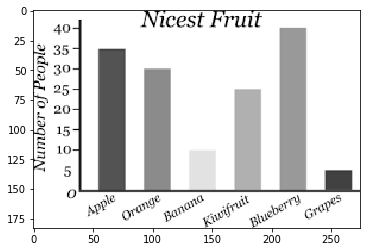

In [8]:
img_gray = rgb2gray(img_ori)   #<class 'numpy.ndarray'>
print(type(img_gray), img_gray.dtype)
plt.imshow(img_gray, cmap=c_map.gray)

<class 'numpy.ndarray'> float64


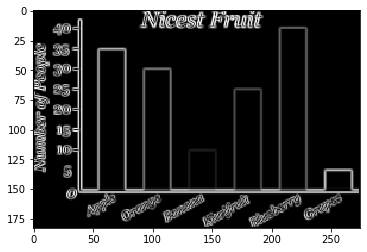

In [9]:
edge_sobel = sobel(img_gray)   # 滤波 边缘检测算子
print(type(edge_sobel), edge_sobel.dtype)
plt.imshow(edge_sobel, cmap=c_map.gray)


0.20235419018627107
bool


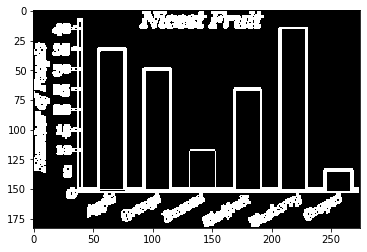

In [10]:
# 二值化
thresh = threshold_otsu(edge_sobel)
print(thresh)
edge_binary = edge_sobel > thresh/3
print(edge_binary.dtype)
plt.imshow(edge_binary, cmap=c_map.gray)


8 vertical_lines detected
[((37, 154), (37, 7)), ((41, 153), (41, 7)), ((55, 153), (55, 31)), ((77, 153), (77, 31)), ((94, 153), (94, 48)), ((115, 153), (115, 48)), ((208, 153), (208, 14)), ((230, 153), (230, 14))]
2 horizontal_lines detected
[((29, 150), (246, 150)), ((28, 153), (273, 153))]


Text(0.5, 1.0, 'Probabilistic Hough line')

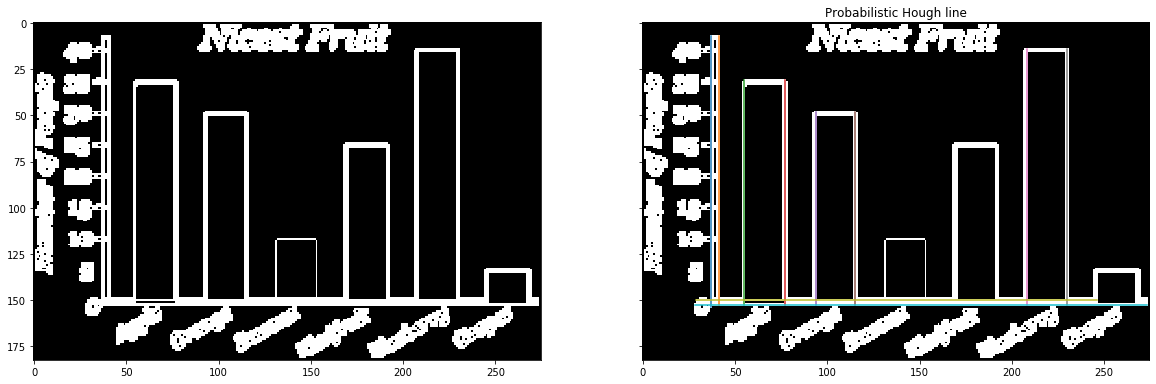

In [15]:
PI = 3.1415926
# 基于概率的霍夫线性变换
l_size_rate = 0.52  #检测直线长度阈值比率：只检测(线长/图像尺寸)比例大于l_size_rate的直线
horizontal_lines = probabilistic_hough_line(edge_binary, threshold=int(edge_binary.shape[1]*l_size_rate),
                    line_length=int(edge_binary.shape[1]*l_size_rate),line_gap=3,
                    theta=np.asarray([PI/2]))
vertical_lines = probabilistic_hough_line(edge_binary, threshold=int(edge_binary.shape[0]*l_size_rate),
                    line_length= int(edge_binary.shape[0]*l_size_rate),line_gap=3,
                    theta=np.asarray([0.0]))

horizontal_lines.sort(key = lambda line: line[0][1])
vertical_lines.sort(key = lambda line: line[0][0])
# remove repetition
thresh = 7
horizontal_lines_temp = horizontal_lines.copy()
for index in range(len(horizontal_lines)-1):
    cur_line = horizontal_lines[index]
    if cur_line not in horizontal_lines_temp:  # 避免之前的remove(next_line)操作造成的错误（避免二次剔除）
        continue
        
    next_line = horizontal_lines[index+1]
    if abs(cur_line[0][1]-next_line[0][1]) < thresh:       
        if abs(cur_line[0][0]-cur_line[1][0]) > abs(next_line[0][0]-next_line[1][0]):
            horizontal_lines_temp.remove(next_line)
        else:
            horizontal_lines_temp.remove(cur_line)

horizontal_lines = horizontal_lines_temp

vertical_lines_temp  = vertical_lines.copy()
for index in range(len(vertical_lines)-1):
    cur_line = vertical_lines[index]
    if cur_line not in vertical_lines_temp:
        continue
        
    next_line = vertical_lines[index+1]
    if abs(cur_line[0][0] - next_line[0][0]) < thresh:
        if abs(cur_line[0][1]-cur_line[1][1]) > abs(next_line[0][1]-next_line[1][1]):
            vertical_lines_temp.remove(next_line)
        else:
            vertical_lines_temp.remove(cur_line)
            
vertical_lines = vertical_lines_temp

#####

#### analyse result ####
print(len(vertical_lines),'vertical_lines detected')
print(vertical_lines)
print(len(horizontal_lines),'horizontal_lines detected')
print(horizontal_lines)

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20, 20))
ax = axes.ravel()   # flatten axes object

#ax[0].imshow(img_gray, cmap=c_map.gray)
ax[0].imshow(edge_binary, cmap=c_map.gray)


for line in vertical_lines + horizontal_lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
    
#ax[1].imshow(np.zeros_like(edge_binary), cmap = c_map.gray)
ax[1].imshow(edge_binary, cmap = c_map.gray)

ax[1].set_title('Probabilistic Hough line')
#plt.close(fig)

293 500
after filter the lines near image boundaries
3 vertical_lines
[((37, 257), (37, 48)), ((61, 255), (61, 77)), ((94, 255), (94, 77))]
4 horizontal_lines
[((32, 50), (442, 50)), ((32, 79), (442, 79)), ((92, 109), (441, 109)), ((32, 254), (442, 254))]


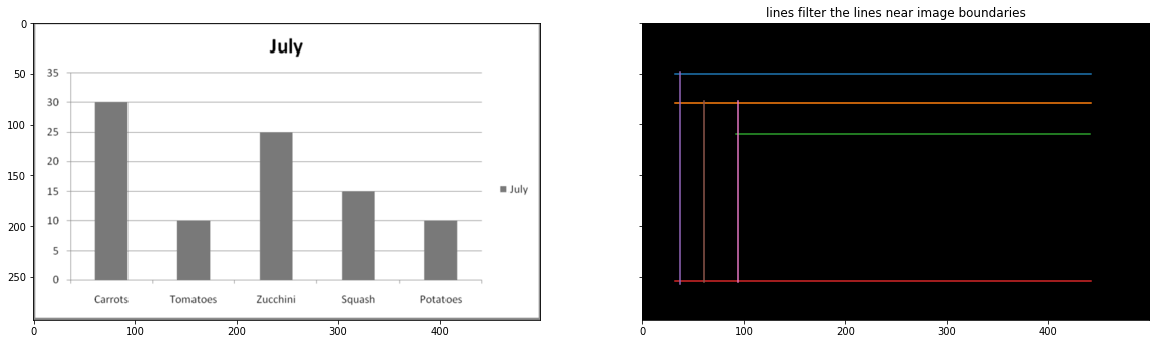

In [21]:
    
#### line filter  ####
# first, filter the lines near by image boundaries and the lines crossing the whole image 
high,width = edge_binary.shape
Off_bounding = 0.03    #距离图像边缘的距离阈值
Length_rate = 0.01
vertical_lines_filted1 = list(filter(lambda line: line[0][0] > Off_bounding*width 
                                     and line[0][0] < width*(1-Off_bounding)
                                     and abs(line[0][1]-line[1][1])<=high*(1-Length_rate), vertical_lines))

horizontal_lines_filted1 = list(filter(lambda line: line[0][1] > Off_bounding*high 
                                       and line[0][1] < high*(1-Off_bounding) 
                                       and abs(line[0][0]-line[1][0])<=width*(1-Length_rate),horizontal_lines))

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20, 20))
ax = axes.ravel()   # flatten axes object

ax[0].imshow(img_gray, cmap=c_map.gray)

for line in horizontal_lines_filted1 + vertical_lines_filted1:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].imshow(np.zeros_like(edge_binary), cmap = c_map.gray)   
ax[1].set_title('lines filter the lines near image boundaries')

print(high, width)
print('after filter the lines near image boundaries')
print(len(vertical_lines_filted1),'vertical_lines')
print(vertical_lines_filted1)
print(len(horizontal_lines_filted1), 'horizontal_lines')
print(horizontal_lines_filted1)

293 500
after filter the shorter lines 
1 vertical_lines
[((37, 257), (37, 48))]
3 horizontal_lines
[((32, 50), (442, 50)), ((32, 79), (442, 79)), ((32, 254), (442, 254))]


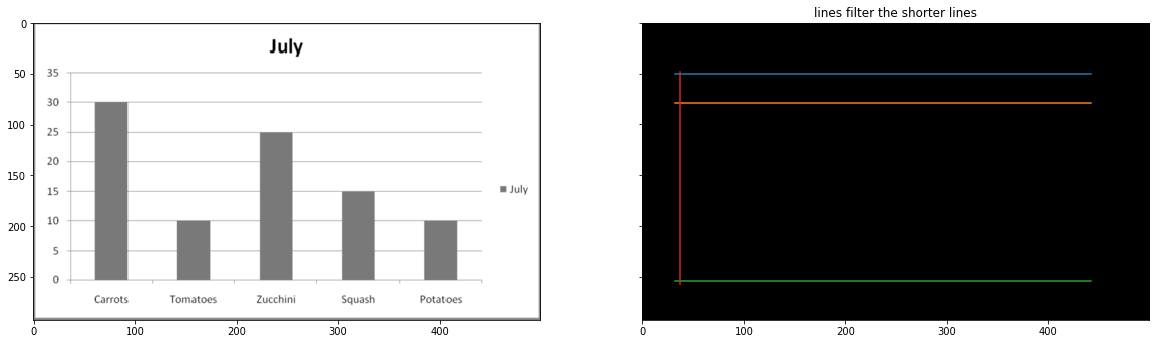

In [22]:
# second, filter the shorter lines ,remanding the longer horizontal_lines and vertical_lines
vertical_lines_filted1_length = list(map(lambda line: abs(line[0][1]-line[1][1]), vertical_lines_filted1))
horizontal_lines_filted1_length = list(map(lambda line: abs(line[0][0]-line[1][0]), horizontal_lines_filted1))

l_rate = 0.9
if len(vertical_lines_filted1) >= 2:
    vertical_lines_longest = max(vertical_lines_filted1_length)
    vertical_lines_filted2 = list(filter(lambda line: abs(line[0][1]-line[1][1]) > vertical_lines_longest*l_rate, 
                                         vertical_lines_filted1))
else:
    vertical_lines_filted2 = vertical_lines_filted1

if len(horizontal_lines_filted1) >= 2:
    horizontal_lines_longest = max(horizontal_lines_filted1_length)
    horizontal_lines_filted2 = list(filter(lambda line: abs(line[0][0]-line[1][0]) > horizontal_lines_longest*l_rate, 
                                           horizontal_lines_filted1))
else:
    horizontal_lines_filted2 = horizontal_lines_filted1
    


fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20, 20))
ax = axes.ravel()   # flatten axes object

ax[0].imshow(img_gray, cmap=c_map.gray)

for line in horizontal_lines_filted2 + vertical_lines_filted2:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].imshow(np.zeros_like(edge_binary), cmap = c_map.gray)   
ax[1].set_title('lines filter the shorter lines')

print(high, width)
print('after filter the shorter lines ')
print(len(vertical_lines_filted2),'vertical_lines')
print(vertical_lines_filted2)
print(len(horizontal_lines_filted2), 'horizontal_lines')
print(horizontal_lines_filted2)   
    

293 500
after filter the mistake lines 
1 vertical_lines
[((37, 257), (37, 48))]
3 horizontal_lines
[((32, 50), (442, 50)), ((32, 79), (442, 79)), ((32, 254), (442, 254))]


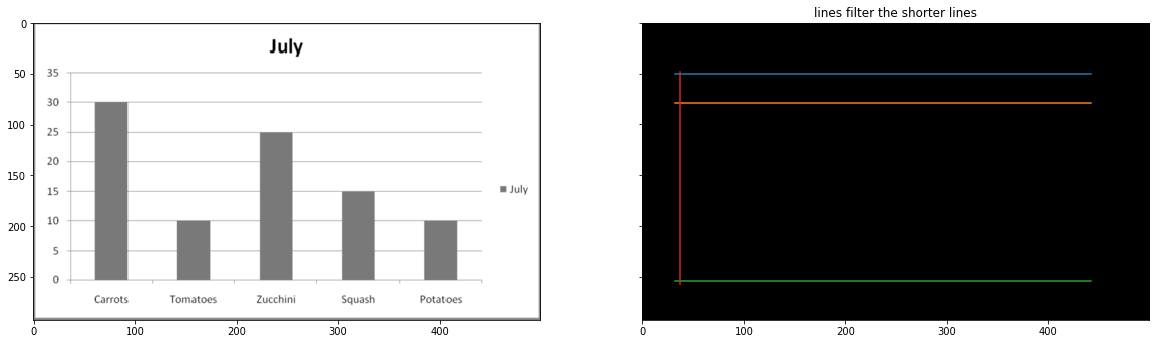

In [23]:
## filter the long line (maybe the edge of long bar)
if horizontal_lines_filted2:
    # the longest horizontal line
    base_line = max(horizontal_lines_filted2, key = lambda line: abs(line[0][0]-line[1][0]))
    base_line_l = min(base_line[0][0], base_line[1][0])
    base_line_r = max(base_line[0][0], base_line[1][0])
    base_line_len = base_line_r - base_line_l
    '''
    vertical_lines_filted3 = list(filter(lambda v_line: base_line_l<v_line[0][0]<base_line_l+base_line_len*1/8
                                        or base_line_r-base_line_len*1/8 < v_line[0][0] < base_line_r,
                                         vertical_lines_filted2))
    '''
    vertical_lines_filted3 = list(filter(lambda v_line: v_line[0][0]<base_line_l+base_line_len*1/7
                                        or base_line_r-base_line_len*1/7 < v_line[0][0],
                                         vertical_lines_filted2))
    
if vertical_lines_filted2:
    base_line = max(vertical_lines_filted2, key = lambda line: abs(line[0][1]-line[1][1]))
    base_line_up = min(base_line[0][1], base_line[1][1])
    base_line_dw = max(base_line[0][1], base_line[1][1])
    base_line_len = base_line_dw - base_line_up
    '''
    horizontal_lines_filted3 = list(filter(lambda h_line: base_line_up<h_line[0][1]<base_line_up+base_line_len*1/8
                                          or base_line_dw - base_line_len*1/8 < h_line[0][1] < base_line_dw,
                                           horizontal_lines_filted2))

    '''
    horizontal_lines_filted3 = list(filter(lambda h_line: h_line[0][1]<base_line_up+base_line_len*1/6
                                          or base_line_dw - base_line_len*1/6 < h_line[0][1],
                                           horizontal_lines_filted2))

    
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20, 20))
ax = axes.ravel()   # flatten axes object

ax[0].imshow(img_gray, cmap=c_map.gray)

for line in horizontal_lines_filted3 + vertical_lines_filted3:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].imshow(np.zeros_like(edge_binary), cmap = c_map.gray)   
ax[1].set_title('lines filter the shorter lines')

print(high, width)
print('after filter the mistake lines ')
print(len(vertical_lines_filted3),'vertical_lines')
print(vertical_lines_filted3)
print(len(horizontal_lines_filted3), 'horizontal_lines')
print(horizontal_lines_filted3)   

final candidate 
1 vertical_lines
[((37, 257), (37, 48))]
2 horizontal_lines
[((32, 50), (442, 50)), ((32, 254), (442, 254))]
[((37, 48), (37, 257)), ((32, 50), (442, 50)), ((32, 254), (442, 254))]


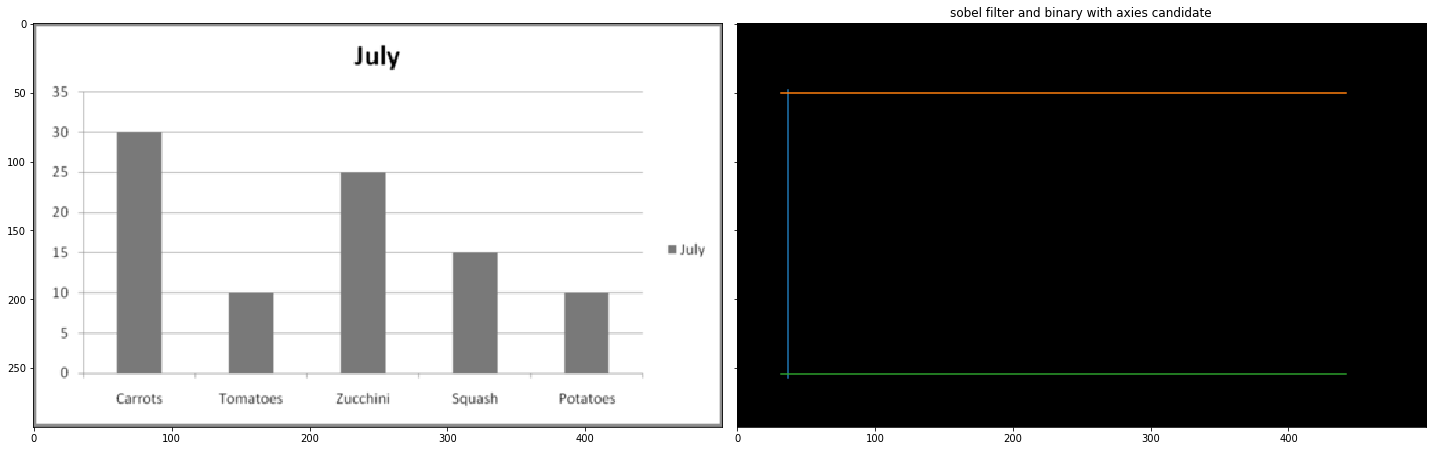

In [24]:
# candidate

def standardization(line):
    p0, p1 = line
    min_x = min([p0[0], p1[0]])
    max_x = max([p0[0], p1[0]])
    min_y = min([p0[1], p1[1]])
    max_y = max([p0[1], p1[1]])
    return ((min_x,min_y),(max_x, max_y))
    
if len(vertical_lines_filted3)>=2:
    v_candidate = [vertical_lines_filted3[0], vertical_lines_filted3[-1]]
else:
    v_candidate = vertical_lines_filted3
if len(horizontal_lines_filted3)>=2:
    h_candidate = [horizontal_lines_filted3[0], horizontal_lines_filted3[-1]]
else:
    h_candidate = horizontal_lines_filted3

y_axis = []
if v_candidate:
    y_axis.append(v_candidate[0])
x_axis = []
if h_candidate:
    x_axis.append(h_candidate[-1])

axis = [standardization(line) for line in x_axis + y_axis]
axis_candidate = [standardization(line) for line in v_candidate + h_candidate]

print('final candidate ')
print(len(v_candidate),'vertical_lines')
print(v_candidate)
print(len(h_candidate), 'horizontal_lines')
print(h_candidate)
print(axis_candidate)                               

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20, 20))
ax = axes.ravel()   # flatten axes object

ax[0].imshow(img_gray, cmap=c_map.gray)

for line in axis_candidate:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].imshow(np.ones_like(edge_binary), cmap = c_map.gray)
ax[1].set_title('sobel filter and binary with axies candidate')


                                
fig.tight_layout()

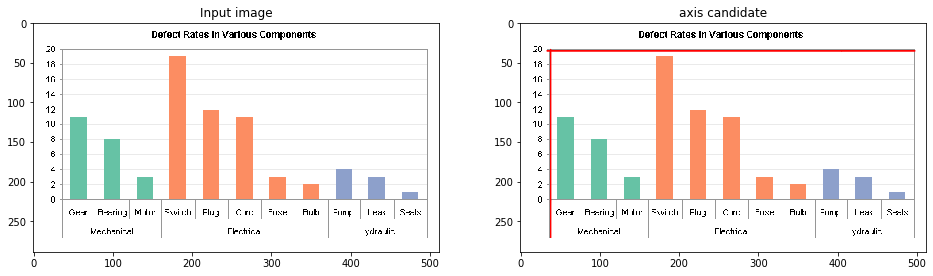

In [11]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax = axes.ravel()   # flatten axes object

#for a in ax:
    #a.set_axis_off()

ax[0].imshow(img_ori)
ax[0].set_title('Input image')

ax[1].imshow(img_ori)
ax[1].set_title('axis candidate')

for axis_l in axis:
    x, y = axis_l[0]
    dx,dy = axis_l[1][0] - axis_l[0][0], axis_l[1][1] - axis_l[0][1]
    axis_patch = mpatches.Arrow(x, y, dx, dy, color='r')
    ax[1].add_patch(axis_patch)

#plt.savefig("")